In [1]:
from charm.toolbox.pairinggroup import PairingGroup,ZR,G1,GT,pair
from charm.toolbox.secretutil import SecretUtil
from charm.toolbox.ABEncMultiAuth import ABEncMultiAuth
from charm.toolbox.symcrypto import AuthenticatedCryptoAbstraction
from charm.core.math.pairing import hashPair as sha2


class MAABE_YJ14(object):
    def __init__(self, groupObj):
        self.util = SecretUtil(groupObj, verbose=False)  #Create Secret Sharing Scheme
        self.group = groupObj    #:Prime order group

    def setup(self):
        '''Global Setup (executed by CA)'''
        #:In global setup, a bilinear group G of prime order p is chosen
        #:The global public parameters, GP and p, and a generator g of G. A random oracle H maps global identities GID to elements of G
    
        #:group contains 
        #:the prime order p is contained somewhere within the group object
        g = self.group.random(G1)
        #: The oracle that maps global identities GID onto elements of G
        #:H = lambda str: g** group.hash(str)
        H = lambda x: self.group.hash(x, G1)
        a = self.group.random()
        b = self.group.random()
        g_a = g ** a
        g_b = g ** b
        GPP = {'g': g, 'g_a': g_a, 'g_b': g_b, 'H': H}
        GMK = {'a': a, 'b': b}
        
        return (GPP, GMK)

    
    def registerUser(self, GPP):
        '''Generate user keys (executed by the user).'''
        g = GPP['g']
        ugsk1 = self.group.random()
        ugsk2 = self.group.random()
        ugpk1 = g ** ugsk1
        ugpk2 = g ** ugsk2
        
        return ((ugpk1, ugsk2), { 'pk': ugpk2, 'sk': ugsk1 }) # (private, public)

    
    def setupAuthority(self, GPP, authorityid, attributes, authorities):
        '''Generate attribute authority keys (executed by attribute authority)'''
        if authorityid not in authorities:
            alpha = self.group.random()
            beta = self.group.random()
            gamma = self.group.random()
            SK = {'alpha': alpha, 'beta': beta, 'gamma': gamma}
            PK = {
                'e_alpha': pair(GPP['g'], GPP['g']) ** alpha, 
                'g_beta': GPP['g'] ** beta, 
                'g_beta_inv': GPP['g'] ** ~beta
            }
            authAttrs = {}
            authorities[authorityid] = (SK, PK, authAttrs)
        else:
            SK, PK, authAttrs = authorities[authorityid]
        for attrib in attributes:
            if attrib in authAttrs:
                continue
            versionKey = self.group.random() # random or really 'choose' ?
            h = GPP['H'](attrib)
            pk = h ** versionKey
            authAttrs[attrib] = {
                'VK': versionKey, #secret
                'PK1': pk, #public
                'PK2': pk ** SK['gamma'] #public
            }
        return (SK, PK, authAttrs)

     
    def keygen(self, GPP, authority, attribute, userObj, USK = None):
        '''Generate user keys for a specific attribute (executed on attribute authority)'''
        if 't' not in userObj:
            userObj['t'] = self.group.random() #private to AA
        t = userObj['t']
        
        ASK, APK, authAttrs = authority
        u = userObj
        if USK is None:
            USK = {}
        if 'K' not in USK or 'KS' not in USK or 'AK' not in USK:
            USK['K'] = \
                (GPP['g'] ** ASK['alpha']) * \
                (GPP['g_a'] ** u['sk']) * \
                (GPP['g_b'] ** t)
            USK['KS'] = GPP['g'] ** t
            USK['AK'] = {}
        AK = (u['pk'] ** (t * ASK['beta'])) * \
            ((authAttrs[attribute]['PK1'] ** ASK['beta']) ** (u['sk'] + ASK['gamma']))
        USK['AK'][attribute] = AK
        return USK

    
    def __encrypt(self, GPP, policy_str, k, authority):
        '''Generate the cipher-text from the content(-key) and a policy (executed by the content owner)'''
        #GPP are global parameters
        #k is the content key (group element based on AES key)
        #policy_str is the policy string
        #authority is the authority tuple
        
        _, APK, authAttrs = authority
        
        policy = self.util.createPolicy(policy_str)
        secret = self.group.random()
        shares = self.util.calculateSharesList(secret, policy)
        shares = dict([(x[0].getAttributeAndIndex(), x[1]) for x in shares])
        
        C1 = k * (APK['e_alpha'] ** secret)
        C2 = GPP['g'] ** secret
        C3 = GPP['g_b'] ** secret
        C = {}
        CS = {}
        D = {}
        DS = {}
        
        for attr, s_share in shares.items():
            k_attr = self.util.strip_index(attr)
            r_i = self.group.random()
            attrPK = authAttrs[attr]
            C[attr] = (GPP['g_a'] ** s_share) * ~(attrPK['PK1'] ** r_i)
            CS[attr] = GPP['g'] ** r_i
            D[attr] = APK['g_beta_inv'] ** r_i
            DS[attr] = attrPK['PK2'] ** r_i
        
        return {'C1': C1, 'C2': C2, 'C3': C3, 'C': C, 'CS': CS, 'D': D, 'DS': DS, 'policy': policy_str}

        
    def __decrypt(self, GPP, CT, user):
        '''Decrypts the content(-key) from the cipher-text (executed by user/content consumer)'''
        UASK = user['authoritySecretKeys']
        USK = user['keys']
        usr_attribs = list(UASK['AK'].keys())
        policy = self.util.createPolicy(CT['policy'])
        pruned = self.util.prune(policy, usr_attribs)
        if pruned == False:
            return False
        coeffs = self.util.getCoefficients(policy)
        
        first = pair(CT['C2'], UASK['K']) * ~pair(CT['C3'], UASK['KS'])
        n_a = 1
        
        ugpk1, ugsk2 = USK
        e_gg_auns = 1
        
        for attr in pruned:
            x = attr.getAttributeAndIndex()
            y = attr.getAttribute()
            temp = \
                pair(CT['C'][y], ugpk1) * \
                pair(CT['D'][y], UASK['AK'][y]) * \
                pair(CT['CS'][y], ~(UASK['KS'] ** ugsk2)) * \
                ~pair(GPP['g'], CT['DS'][y])
            e_gg_auns *= temp ** (coeffs[x] * n_a)
        return CT['C1'] / (first / e_gg_auns)

    def __random_key(self):
        return self.group.random(GT)

    def encrypt(self, GPP, policy_str, M, authority):
        if type(M) != bytes and type(policy_str) != str:
            raise Exception("message and policy not right type!")
        k = self.__random_key()
        c1 = self.__encrypt(GPP, policy_str, k, authority)
        # instantiate a symmetric enc scheme from this key
        cipher = AuthenticatedCryptoAbstraction(sha2(k))
        c2 = cipher.encrypt(M)
        return { 'c1':c1, 'c2':c2 }
    
    def decrypt(self, GPP, ct, user):
        c1, c2 = ct['c1'], ct['c2']
        key = self.__decrypt(GPP, c1, user)
        if key is False:
            raise Exception("failed to decrypt!")
        cipher = AuthenticatedCryptoAbstraction(sha2(key))
        return cipher.decrypt(c2)

    
    def ukeygen(self, GPP, authority, attribute, userObj):
        '''Generate update keys for users and cloud provider (executed by attribute authority?)'''
        ASK, _, authAttrs = authority
        oldVersionKey = authAttrs[attribute]['VK']
        newVersionKey = oldVersionKey
        while oldVersionKey == newVersionKey:
            newVersionKey = self.group.random()
        authAttrs[attribute]['VK'] = newVersionKey
        
        u_uid = userObj['sk']
        UKs = GPP['H'](attribute) ** (ASK['beta'] * (newVersionKey - oldVersionKey) * (u_uid + ASK['gamma']))
        UKc = (newVersionKey/oldVersionKey, (oldVersionKey - newVersionKey)/(oldVersionKey * ASK['gamma']))
        
        authAttrs[attribute]['PK1'] = authAttrs[attribute]['PK1'] ** UKc[0]
        authAttrs[attribute]['PK2'] = authAttrs[attribute]['PK2'] ** UKc[0]
        
        return { 'UKs': UKs, 'UKc': UKc }

    
    def skupdate(self, USK, attribute, UKs):
        '''Updates the user attribute secret key for the specified attribute (executed by non-revoked user)'''
        USK['AK'][attribute] = USK['AK'][attribute] * UKs

    
    def ctupdate(self, GPP, CT, attribute, UKc):
        '''Updates the cipher-text using the update key, because of the revoked attribute (executed by cloud provider)'''
        CT['C'][attribute] = CT['C'][attribute] * (CT['DS'][attribute] ** UKc[1])
        CT['DS'][attribute] = CT['DS'][attribute] ** UKc[0]

In [2]:
import time

In [3]:
groupObj = PairingGroup('SS1024')
maabe = MAABE_YJ14(groupObj)
GPP, GMK = maabe.setup()

In [4]:
GPP

{'g': [26250108946939348897732336791925524216287363392915263030976791180613103796987521204182763541138832857910055487564913821458929966647632166159503381200636154851574363350377450098400880693940446417956783231703013970110529768128330076014527870574647898027465267524834263807066032516131243435478143575303549222707115, 11730990274480942120760244112026658840312057531720762104541798011900302368526271686274966563259668726459740257790720442461615994949706501861455388082670130715996637365751637509421617411043150556081585743741891352861306272724201610551083644372414468032258176652746407838248341188867748135266364591736921536868974],
 'g_a': [36015633098810460862452447490120150020952640394580588238570589624229308015132742920195532691815106806566660521176686615677410744762479639277924598900479780550147756854923580455831493707832983567284256439729999368723787795573404116023769296985314521713352986838186708677390870818708913561058189753685005409675181, 48323823551805935760946616420686781994842943

In [5]:
attributes = []
for i in range(1,61):
    attributes.append("ATTR"+str(i))


In [6]:
authorities60= {}
    
authority1 = "authority1"

maabe.setupAuthority(GPP, authority1, attributes, authorities60)
print(1000)

1000


In [7]:
users = {}
alice = { 'id': 'alice', 'authoritySecretKeys': {}, 'keys': None}
alice['keys'], users[alice['id']] = maabe.registerUser(GPP)
authority1 = "authority1"
for attr in attributes:
    maabe.keygen(GPP, authorities60[authority1], attr, users[alice['id']], alice['authoritySecretKeys'])

In [8]:
#alice

In [9]:
def AASetup_time(maabe, GPP, authorityAttributes):
    start_time = time.time()
    authorities = {}
    
    authority1 = "authority1"

    maabe.setupAuthority(GPP, authority1, authorityAttributes, authorities)
    end_time = time.time()
    return end_time - start_time

In [10]:
def userKeygen_time(maabe, GPP, authorities, userAttributes):
    users = {}
    alice = { 'id': 'alice', 'authoritySecretKeys': {}, 'keys': None }
    alice['keys'], users[alice['id']] = maabe.registerUser(GPP)
    authority1 = "authority1"
    start_time = time.time()
    for attr in userAttributes:
        maabe.keygen(GPP, authorities[authority1], attr, users[alice['id']], alice['authoritySecretKeys'])
    end_time = time.time()
    return end_time - start_time

In [11]:
def encrypt_time(GPP, maabe, authorities, i, user):
    if i == 0:
        i += 1
    msg = b'Hello World, I am a sensitive record!'
    policy_str = gen_policy(i)
    start_time = time.time()
    CT = maabe.encrypt(GPP, policy_str, msg, authorities['authority1'])
    end_time = time.time()
    encrypt_time = end_time - start_time
    
    start_time = time.time()
    PT = maabe.decrypt(GPP, CT, user)
    end_time = time.time()
    decrypt_time = end_time - start_time

    return [encrypt_time, decrypt_time]

In [22]:
def gen_policy(num_attr):
    if num_attr == 0 or num_attr == 1:
        return "((ATTR1))"
    policy = '(('
    for i in range(num_attr):
        if i % 2 == 0:
            policy += 'ATTR' + str(i+1) + ') OR '
        else:
            policy += '(ATTR' + str(i+1) + ' AND '
    if num_attr%2 != 0:
        policy = policy[:-4]
    else:
        policy = policy[:-5]
    policy += '))'
    if num_attr%2 != 0:
        policy = policy[:len(policy)-3]+')'
    if policy[len(policy)-2] != ')':
        policy += ')'
    return policy

In [13]:
AA_time = []
for i in range(1, 61):
    j = i
    if i == 0:
        j = 1
    AA_time.append(AASetup_time(maabe, GPP, attributes[:j]))

In [14]:
import matplotlib.pyplot as plt

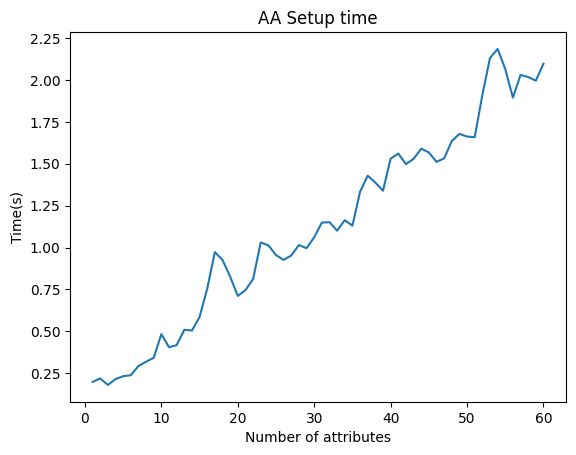

In [15]:
# Vẽ đồ thị
plt.plot(list(range(1,61)), AA_time)
# Thêm tiêu đề và nhãn trục
plt.title('AA Setup time')
plt.xlabel('Number of attributes')
plt.ylabel('Time(s)')
plt.savefig('AASetup.png')

# Hiển thị đồ thị
plt.show()


In [16]:
userKeygen_times = []
for i in range(1,61):
    j=i
    if i == 0:
        j = 1
    userKeygen_times.append(userKeygen_time(maabe, GPP, authorities60, attributes[:j]))

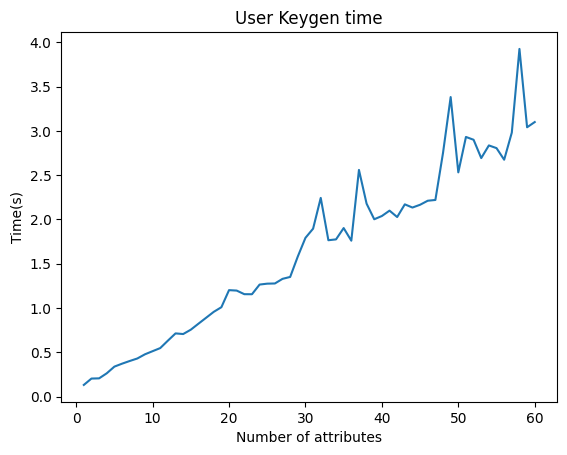

In [17]:
plt.plot(list(range(1,61)), userKeygen_times)
plt.title('User Keygen time')
plt.xlabel('Number of attributes')
plt.ylabel('Time(s)')
plt.savefig('UserKeygen.png')


In [18]:
gen_policy(17)

'((ATTR1) OR (ATTR2 AND ATTR3) OR (ATTR4 AND ATTR5) OR (ATTR6 AND ATTR7) OR (ATTR8 AND ATTR9) OR (ATTR10 AND ATTR11) OR (ATTR12 AND ATTR13) OR (ATTR14 AND ATTR15) OR (ATTR16 AND ATTR17)'

In [19]:
gen_policy(18)

'((ATTR1) OR (ATTR2 AND ATTR3) OR (ATTR4 AND ATTR5) OR (ATTR6 AND ATTR7) OR (ATTR8 AND ATTR9) OR (ATTR10 AND ATTR11) OR (ATTR12 AND ATTR13) OR (ATTR14 AND ATTR15) OR (ATTR16 AND ATTR17) OR (ATTR18))'

In [24]:
encrypt_times = []
decrypt_times = []
for i in range(1,61):
    j = i
    if i == 0:
        j = 1
    k = encrypt_time(GPP, maabe, authorities60, j, alice)
    encrypt_times.append(k[0])
    decrypt_times.append(k[1])
    

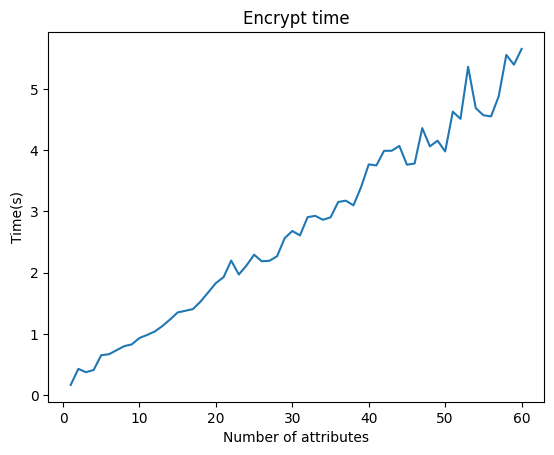

In [25]:
plt.plot(list(range(1,61)), encrypt_times)
plt.title('Encrypt time')
plt.xlabel('Number of attributes')
plt.ylabel('Time(s)')
plt.savefig('Encrypt.png')


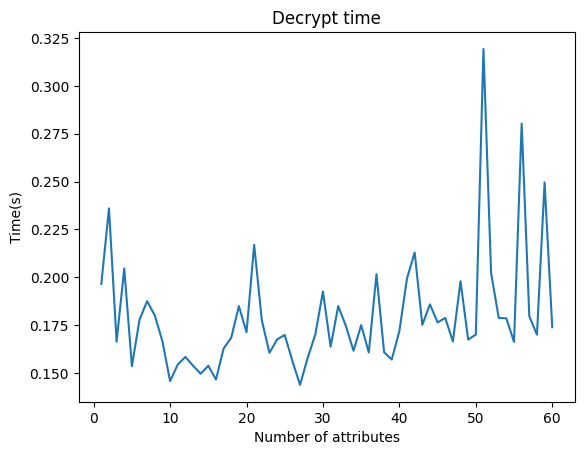

In [26]:
plt.plot(list(range(1,61)), decrypt_times)
plt.title('Decrypt time')
plt.xlabel('Number of attributes')
plt.ylabel('Time(s)')
plt.savefig('Decrypt.png')

In [27]:
list(range(0,451,6))

[0,
 6,
 12,
 18,
 24,
 30,
 36,
 42,
 48,
 54,
 60,
 66,
 72,
 78,
 84,
 90,
 96,
 102,
 108,
 114,
 120,
 126,
 132,
 138,
 144,
 150,
 156,
 162,
 168,
 174,
 180,
 186,
 192,
 198,
 204,
 210,
 216,
 222,
 228,
 234,
 240,
 246,
 252,
 258,
 264,
 270,
 276,
 282,
 288,
 294,
 300,
 306,
 312,
 318,
 324,
 330,
 336,
 342,
 348,
 354,
 360,
 366,
 372,
 378,
 384,
 390,
 396,
 402,
 408,
 414,
 420,
 426,
 432,
 438,
 444,
 450]